# Tweeting about Disaster
## Using Neural Networks to Detect Tweets About Real Crises

Flatiron School Data Science: Project 4

Advanced Machine Learning Topics
- **Author**: Zaid Shoorbajee
- **Instructor**: Morgan Jones
- **Pace**: Flex, 40 weeks

<img src="./images/moshed_twitter_tiles-2.jpg" alt="Twitter logo art.">

## Business Case

An international news outlet, *The Flatiron Post*, wants to be able to report on stories of crises and natural disasters in a prompt manner. News about plane crashes, hurricanes, earthquakes, terrorist threats, and other topics occurs without warning. Being late to the story can mean not only losing to the competition, but also leaving your audience in the dark while speculation runs amok. 

The *Post* wants to tap into Twitter as a resource in order to detect such disasters in real time, and it’s employing a data scientist for the task. Twitter is a fire hose of information; there is a lot more noise than signal, and reporters would waste a lot of time staring at their Twitter feeds just waiting for disaster tweets. But chances are that if a disaster is occurring, someone is tweeting about it. 

The task of the data scientist is to use natural language processing (NLP) and machine learning in order to systematically tell if a tweet is about a real disaster or not. Such tweets can then theoretically be presented to the newsroom in a separate feed. Reporters can then choose to pursue that story or not.

## Data Undersanding <a name="data_understanding"></a>

### NLP <a name="nlp"></a>

The core type of data being used for this task is the text of tweets. This is **unstructured data** and requires natural language processing (NLP) techniques in order to be interpretable by a machine learning model, such as a neural network.

Working with natural langauge is messy; disaster and non-disaster tweets can use many of the same words, but context changes everything. The following two tweets both have the words "explosion" and "fire" in them. For any literate person, it's obvious which is about a real disaster and which is not.

<blockquote class="twitter-tweet"><p lang="en" dir="ltr">BREAKING: Small explosion and fire at the Hoover Dam; cause unknown <a href="https://t.co/Y2YfPVvGaH">pic.twitter.com/Y2YfPVvGaH</a></p>&mdash; BNO News (@BNONews) <a href="https://twitter.com/BNONews/status/1549444981408022528?ref_src=twsrc%5Etfw">July 19, 2022</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

___

<blockquote class="twitter-tweet"><p lang="en" dir="ltr">spicy dan dan noodles is an explosion of flavor. my mouth is def on fire though.🥹😛💙</p>&mdash; kat ᵍᵐ (@jpegkat) <a href="https://twitter.com/jpegkat/status/1549202432688697344?ref_src=twsrc%5Etfw">July 19, 2022</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

For a computer, however, it's not so simple. To make tweets interpretable by a neural network, this project uses the following NLP techniques:

* Tokenization
* Lemmatization
* Removing stop words
* TF-IDF Vectorization
* Part-of-speech tagging
* Named-entity recognition
* Meta-feature extraction
    * Character count, word count, stop word rate, etc.

The idea is that converting tweets into the signals listed above should help a machine learning model to discern the difference between a disaster tweet and non-disaster tweet.

### Dataset <a name="dataset"></a>

This project uses the [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/competitions/nlp-getting-started) dataset from Kaggle. This is a dataset recommended by Kaggle for those looking to get started with NLP.

The labeled training set contains **7,613** entries with the following features:
* **id:** Arbitrary identifier
* **keyword:** Search phrase used to collect tweet
* **location:** User-generated location for the tweet's account
* **text:** The text of the tweet
* **target:** Binary label for disaster (1) and non-disaster (0) tweets. Labeled by humans.

## Modeling

This project ultimately is a binary classification task. I will be using [TensorFlow through the Keras interface](https://www.tensorflow.org/api_docs/python/tf/keras) in order to build a neural network. The neural network will be trained on a preprocessed version of the disaster tweets dataset (which I will prepare in this notebook).

## Scoring and Evaluation

The business case is that a news outlet wants to make sure it doesn't miss important crises that should be reported on. Therefore, it's important to know what level of false negatives the model produces, which is aptly measured by the **recall score:**

recall = (true positives) / (false negatives + true positives)

In [1]:
import time
start_time = time.time()
def time_check(start=None):
    if start:
        t = time.time() - start
    else:
        t = time.time() - start_time
    print(f'Time check: {t//60:.0f} minutes and {t%60:.0f} seconds')

In [2]:
# Imports

import numpy as np
import pandas as pd
import warnings
warnings.simplefilter(action="ignore", category=pd.core.common.SettingWithCopyWarning)

from nltk import FreqDist
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, log_loss, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed

import re
from collections import OrderedDict, Counter
import itertools
import string

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline

pd.options.display.max_colwidth = 150
seed = 7
np.random.seed(seed)

## Data Preparation

In [3]:
# Loading and previewing the dataset

df = pd.read_csv('./data/disaster_tweets/train.csv')
df.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires,1
6,10,NaN,NaN,"#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas",1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in the woods...,1
8,14,NaN,NaN,There's an emergency evacuation happening now in the building across the street,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our area...,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
df.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

### Keyword and location columns

The `location` column doesn't have much usable information in some cases it's just nonsense:

In [6]:
print('Sample of some of the location values')
df['location'].unique()[7:17].tolist()

Sample of some of the location values


['World Wide!!',
 'Paranaque City',
 'Live On Webcam',
 'milky way',
 'GREENSBORO,NORTH CAROLINA',
 'England.',
 'Sheffield Township, Ohio',
 'India',
 'Barbados',
 'Anaheim']

Therefore I can't use the `location` column without some pre-processing. I will fill the missing values with `location_missing` for now. Later, when I'm processing more of the text data, I'll extract some information from this column.

In [7]:
df['location'] = df['location'].fillna('location_missing')

The `keyword` column shows what was used to search for relevant tweets. Realistically, `keyword` isn't a feature that will always be available when trying to predict tweets spotted "in the wild." Furthermore, the client might add or remove keywords from its repertoire of search terms. For these reasons, I won't be using it as a feature to train the model. 

However, this column can give use insight as to what kinds of tweets the keywords yield. 

In [8]:
df['keyword'].value_counts(dropna=False)

NaN                      61
fatalities               45
armageddon               42
deluge                   42
body%20bags              41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 222, dtype: int64

`keyword` has 61 missing values

In [9]:
# Filling missing values with 'missing_keyword' so I can visualize.

df['keyword'] = df['keyword'].fillna('keyword_missing')

In [10]:
# %20 is the HTML entity for a "space" character

df['keyword'] = df['keyword'].apply(lambda x: x.replace('%20', ' '))

In [11]:
# Creating a separate DF for visualization purposes

df_kw = df[['keyword', 'target']]
df_kw['kw_target_mean'] = df_kw.groupby('keyword')['target'].transform('mean')

#### Visualizing distribution of class (0 and 1) by keyword

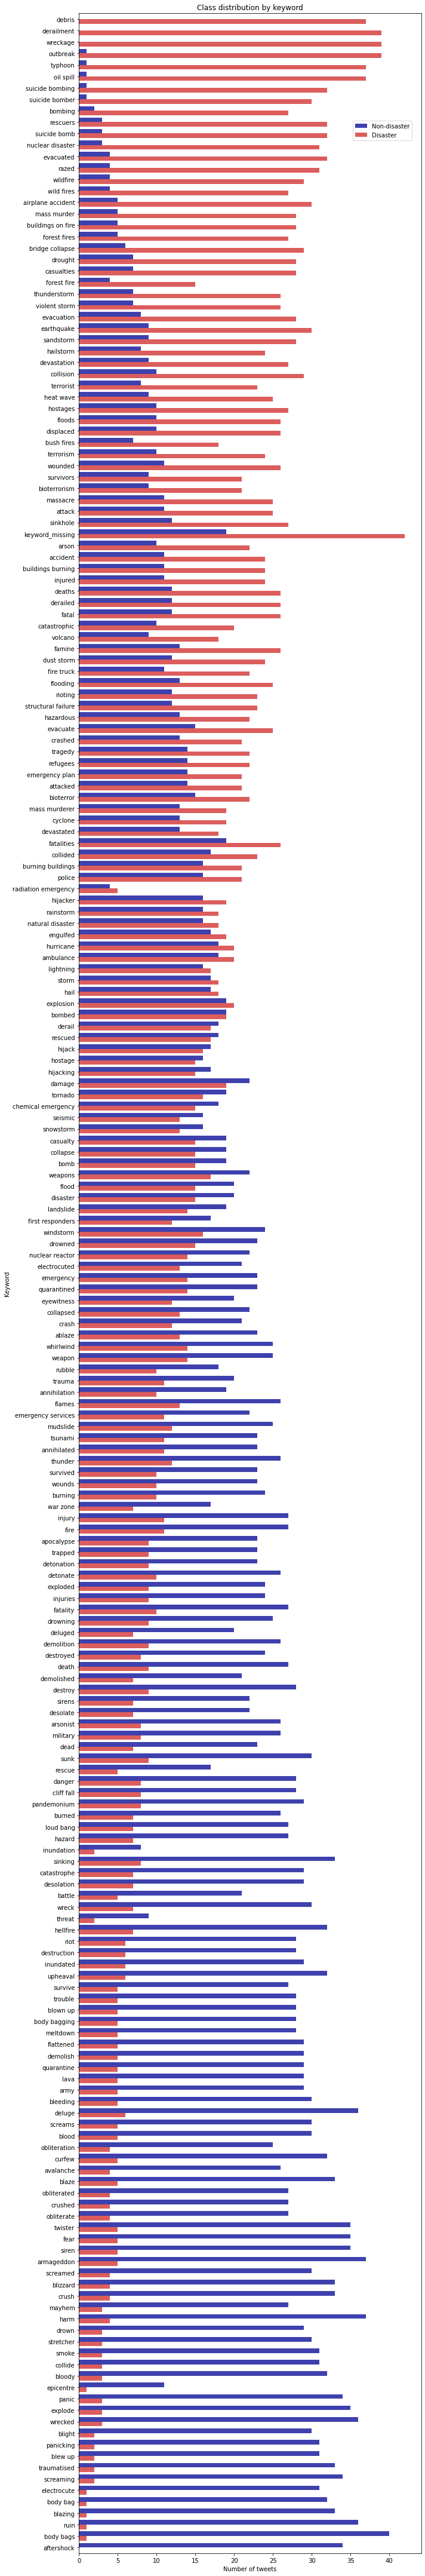

In [12]:
color_non = '#2c2fbf'
color_disaster ='#f14848'

fig, ax = plt.subplots(figsize=(10, 60))

sns.countplot(
    y=df_kw.sort_values(by='kw_target_mean', ascending=False)['keyword'],
    hue=df_kw.sort_values(by='kw_target_mean', ascending=False)['target'],
    palette=[color_non, color_disaster],
    ax=ax
)
ax.set_title('Class distribution by keyword')
ax.set_xlabel('Number of tweets'),
ax.set_ylabel('Keyword')
fig.set_facecolor('white')
plt.legend(['Non-disaster', 'Disaster'], loc=(.8,.95))
plt.tight_layout()
# plt.savefig('./images/keywords_classes.png', dpi=100)
plt.show()

That's a lot to take in. These search terms are generated by humans trying to intuit what words would be in a tweet about a disaster. But clearly, some search terms yield more disaster tweets than others. Let's zero in on the keywords with the lowest and highest rates of disaster tweets. This can inform the client about what words to avoid using when searching for relevant tweets.

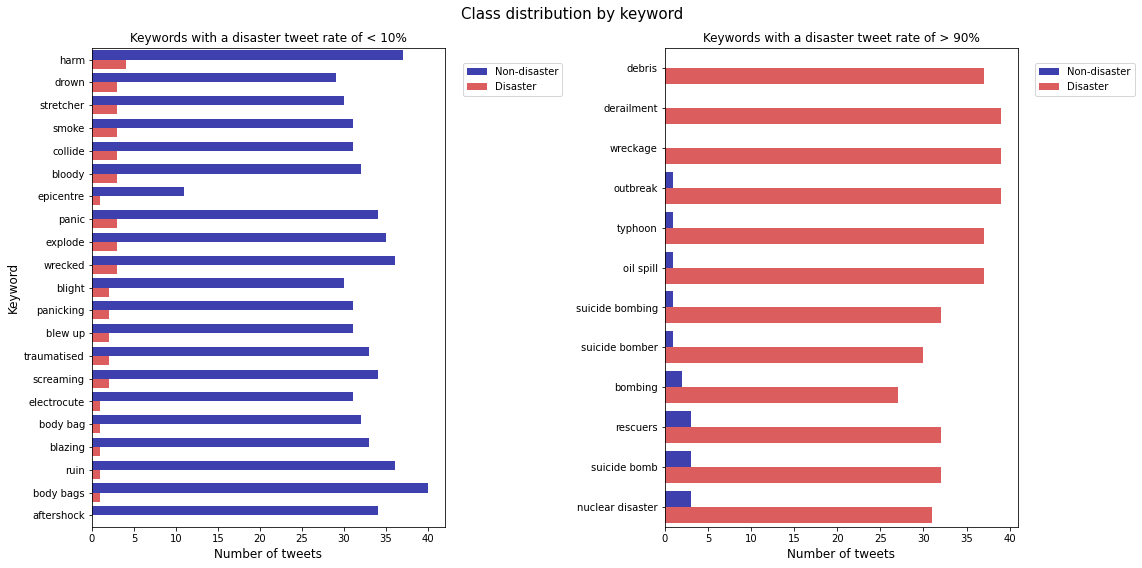

In [271]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 8))

sns.countplot(
    y=df_kw.sort_values(by='kw_target_mean', ascending=False)['keyword'][df_kw['kw_target_mean'] < 0.10],
    hue=df_kw.sort_values(by='kw_target_mean', ascending=False)['target'][df_kw['kw_target_mean'] < 0.10],
    palette=[color_non, color_disaster],
    ax=axes[0]
)
axes[0].set_title('Keywords with a disaster tweet rate of < 10%')
axes[0].set_xlabel('Number of tweets', size=12),
axes[0].set_ylabel('Keyword', size=12)
axes[0].legend(['Non-disaster', 'Disaster'], loc=(1.05,.9))

sns.countplot(
    y=df_kw.sort_values(by='kw_target_mean', ascending=False)['keyword'][df_kw['kw_target_mean'] > 0.90],
    hue=df_kw.sort_values(by='kw_target_mean', ascending=False)['target'][df_kw['kw_target_mean'] > 0.90],
    palette=[color_non, color_disaster],
    ax=axes[1], 
)
axes[1].set_title('Keywords with a disaster tweet rate of > 90%')
axes[1].set_xlabel('Number of tweets', size=12),
axes[1].set_ylabel('')
axes[1].legend(['Non-disaster', 'Disaster'], loc=(1.05,.9))
fig.suptitle('Class distribution by keyword', size=15)
fig.set_facecolor('white')
plt.tight_layout()
plt.savefig('./images/keywords_90_10.png', dpi=500)
plt.show()

**We find that there are a lot more keywords on the lower end. This is perhaps a sign that the newsroom should revise the search terms it's using to find these tweets.**

### Tweets and Target
The main feature is `text`, which is the full text of the given tweet. Each tweet is labeled in `target` as referring to a disaster (1) or not (0).
#### Duplicate tweets
Before proceeding, I'll check if there are any tweets that are duplicated.

In [15]:
df['text'].duplicated().sum()

110

There are numerous duplicate tweets, perhaps tweeted by different accounts. The most concerning part of this is that some of these duplicates have contradicting labels. Here are a few examples:

In [16]:
df[df['text'] == "He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam"]

,id,keyword,location,text,target
3240,4656,engulfed,location_missing,He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam,0
3243,4659,engulfed,Kuwait,He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam,1
3248,4669,engulfed,Bahrain,He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam,1
3251,4672,engulfed,location_missing,He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam,0
3261,4684,engulfed,location_missing,He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam,0
3266,4691,engulfed,location_missing,He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam,0


In [17]:
df[df['text'] == ".POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4"]

,id,keyword,location,text,target
2830,4068,displaced,Pedophile hunting ground,.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4,1
2831,4072,displaced,Pedophile hunting ground,.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4,1
2832,4076,displaced,Pedophile hunting ground,.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4,0
2833,4077,displaced,Pedophile hunting ground,.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4,1


In [18]:
df[df['text'] == "Caution: breathing may be hazardous to your health."]

,id,keyword,location,text,target
4232,6012,hazardous,location_missing,Caution: breathing may be hazardous to your health.,1
4235,6017,hazardous,location_missing,Caution: breathing may be hazardous to your health.,0


In [19]:
df[df['text'] == "like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit"]

,id,keyword,location,text,target
1221,1760,buildings burning,dallas,like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit,1
1349,1950,burning buildings,dallas,like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit,0


It seems that some of these tweets were labeled sloppily or are difficult to interpret. In any case, having identical tweets labeled differently will cause unwanted noise in the model. Therefore, I'll drop all duplicated tweets, which account for less than 2% of the dataset.

In [20]:
# Proportion of duplicate tweets

df['text'].duplicated().sum() / len(df)

0.0144489688690398

In [21]:
df = df.drop_duplicates(subset = 'text', keep=False)

#### Separating features from target

In [22]:
tweets = df.drop(columns='target')
target = df['target']

In [23]:
print('Distribution of Target')
print()
print(target.value_counts())
print()
print('Normalized:')
print(target.value_counts(normalize=True))

Distribution of Target

0    4284
1    3150
Name: target, dtype: int64

Normalized:
0    0.576271
1    0.423729
Name: target, dtype: float64


About 42% of the tweets have been labeled as actual disaster tweets. This is not a major imbalance, and this I won't need to artificially rebalance the dataset.

#### Train-Test Split

X_train: Used for training the model and extracting meta-data about tweets

X_val: Used for selecting a model

X_test: Used to score the final model

In [24]:
# Splitting the full dataset into training and testing data

X_train, X_test, y_train, y_test = train_test_split(
    tweets, target, test_size=0.2, random_state=seed
)

# Splitting off a validation set

X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test, test_size=.5, random_state=seed
)

### Cleaning and tokenizing the tweet text

In [25]:
# Saving a copy of untouched tweets
X_train_tweets_unprocessed = X_train.copy()['text'] 

X_test_tweets_unprocessed = X_test.copy()['text'] 

X_val_tweets_unprocessed = X_val.copy()['text'] 

In [26]:
# Make everything lowercase

X_train['text'] = X_train['text'].apply(lambda x: x.lower())

In [27]:
X_train.head(10)

,id,keyword,location,text
39,57,ablaze,Paranaque City,ablaze for you lord :d
418,607,arsonist,heccfidmss@gmail.com,@local_arsonist @diamorfiend the legal system never forgets
4916,7001,mayhem,"Orlando, FL",i guess ill never be able to go to mayhem...
2126,3054,deaths,location_missing,bigamist and his û÷firstûª wife are charged in the deaths of his û÷secondûª pregnant wife her child 8 her mother her nephew 1 and their uû_
1054,1523,body bags,ANYWEHERE !!,status: last seen buying body bags.
688,992,blazing,location_missing,@baseballquotes1 i have a 32 inch dynasty
3193,4584,emergency plan,Indiana,do you have a plan? emergency preparedness for #families of\nchildren with special needs http://t.co/rdovqauax5 #autism #specialneeds
194,273,ambulance,Loveland Colorado,@kiwi_karyn check out what's in my parking lot!! he said that until last year it was an ambulance in st johns. http://t.co/hpvodud7ip
7495,10722,wreck,"Greenville, S.C.",greer man dies in wreck http://t.co/n2qzbmzuly
5987,8550,screams,"Pennsylvania, USA",*screams internally*


### Dealing with URLs

Many tweets contain URLs, which, from an NLP standpoint are essentially random strings and thus won't be useful as vectorized tokens. But before I remove them, I will turn the presence of a URL into a binary feature.

In [28]:
def binary_url(text):
    """
    Returns 1 if a string contains a URL, else returns 0.
    """
    search = re.search(pattern=r'http\S+', string=text)
    return int(bool(search))

# Making a series indicating whether the tweet has a URL. I will use this later when extracting more meta-features.

has_url_Series_train = X_train['text'].apply(binary_url).rename('has_url')

In [29]:
# Removing URLs from all tweets

X_train['text'] = X_train['text'].apply(
    lambda x: re.sub(
        pattern=r'http\S+', repl='', string=x)
        )

### Tokenizing tweets

#### I plan to make multiple tokenized versions of each tweet.
* Basic version: Any word with at least two letters. Strips the symbols for hashtags (#) and mentions(@)
* Basic version, excluding stop words
* Lemmatized version of basic version
* Lemmatized version of basic version, exluding stop words.

In [30]:
example_tweet = X_train['text'].loc[1245]
example_tweet

'shootings explosions hand grenades thrown at cars and houses &amp; vehicles and buildings set on fire. it all just baffles me.is this sweden?'

In [31]:
token_pattern = r"[a-zA-Z]+'?[a-zA-Z]+|\b[iIaA]\b"
# Pattern: Any word with at least two characters, including up to one apostrophe
# Also captures the English words "I" and "and".

tokenizer = RegexpTokenizer(token_pattern)

Let's see how well the tokenizer does with the pattern I used above.

In [32]:
print(tokenizer.tokenize(example_tweet))

['shootings', 'explosions', 'hand', 'grenades', 'thrown', 'at', 'cars', 'and', 'houses', 'amp', 'vehicles', 'and', 'buildings', 'set', 'on', 'fire', 'it', 'all', 'just', 'baffles', 'me', 'is', 'this', 'sweden']


That seems to work. However, 'amp' is an artifact of "&amp;", which is the HTML entity for an ampersand ("&").

I will replace any instance of "&amp;" with the word "and" in the original text.

In [33]:
X_train['text'] = X_train['text'].apply(lambda x: re.sub("&amp;", "and", x))

In [34]:
example_tweet = X_train['text'].loc[1245]
example_tweet

'shootings explosions hand grenades thrown at cars and houses and vehicles and buildings set on fire. it all just baffles me.is this sweden?'

In [35]:
print(tokenizer.tokenize(example_tweet))

['shootings', 'explosions', 'hand', 'grenades', 'thrown', 'at', 'cars', 'and', 'houses', 'and', 'vehicles', 'and', 'buildings', 'set', 'on', 'fire', 'it', 'all', 'just', 'baffles', 'me', 'is', 'this', 'sweden']


In [36]:
X_train['tokens'] = X_train['text'].apply(tokenizer.tokenize)

In [37]:
# Check most common tokens

top_20_tokens = FreqDist(X_train['tokens'].explode()).most_common(20)
top_20_tokens

[('the', 2575),
 ('a', 1721),
 ('in', 1558),
 ('to', 1526),
 ('of', 1426),
 ('and', 1368),
 ('i', 1141),
 ('is', 742),
 ('for', 696),
 ('on', 683),
 ('you', 625),
 ('my', 536),
 ('that', 462),
 ('it', 444),
 ('by', 420),
 ('at', 419),
 ('with', 411),
 ('this', 363),
 ('from', 319),
 ('be', 313)]

#### All tweets have been tokenized. Now I will make a version without stop words.

To make a comprehensive list of stop words, I will combine the default lists from the NLTK and SpaCy libraries.

In [38]:
sw_spacy = list(nlp.Defaults.stop_words)
sw_nltk = stopwords.words('english')
stopword_list = list(set(sw_spacy + sw_nltk))

In [39]:
X_train['tokens_no_sw'] = \
    X_train['tokens'].apply(
        lambda x: [w for w in x if not w in stopword_list]
    )

In [40]:
# Check most common tokens (without stop words)

FreqDist(X_train['tokens_no_sw'].explode()).most_common(20)

[('like', 271),
 ('fire', 189),
 ("i'm", 189),
 ('new', 182),
 ('news', 176),
 ('people', 170),
 ('video', 133),
 ('emergency', 127),
 ('police', 115),
 ('disaster', 113),
 ('time', 106),
 ('day', 102),
 ('body', 101),
 ('man', 97),
 ('suicide', 96),
 ('rt', 95),
 ('know', 95),
 ('california', 91),
 ('storm', 90),
 ('world', 89)]

"i'm" should also be considered a stop word

In [41]:
stopword_list.extend(["i'm"])

In [42]:
X_train['tokens_no_sw'] = \
    X_train['tokens'].apply(
        lambda x: [w for w in x if not w in stopword_list]
    )

In [43]:
# Check most common tokens (without stop words)

top_20_tokens_no_sw = FreqDist(X_train['tokens_no_sw'].explode()).most_common(20)
top_20_tokens_no_sw

[('like', 271),
 ('fire', 189),
 ('new', 182),
 ('news', 176),
 ('people', 170),
 ('video', 133),
 ('emergency', 127),
 ('police', 115),
 ('disaster', 113),
 ('time', 106),
 ('day', 102),
 ('body', 101),
 ('man', 97),
 ('suicide', 96),
 ('rt', 95),
 ('know', 95),
 ('california', 91),
 ('storm', 90),
 ('world', 89),
 ('crash', 86)]

Previewing the restulting features:

In [44]:
X_train.head()

,id,keyword,location,text,tokens,tokens_no_sw
39,57,ablaze,Paranaque City,ablaze for you lord :d,"[ablaze, for, you, lord]","[ablaze, lord]"
418,607,arsonist,heccfidmss@gmail.com,@local_arsonist @diamorfiend the legal system never forgets,"[local, arsonist, diamorfiend, the, legal, system, never, forgets]","[local, arsonist, diamorfiend, legal, system, forgets]"
4916,7001,mayhem,"Orlando, FL",i guess ill never be able to go to mayhem...,"[i, guess, ill, never, be, able, to, go, to, mayhem]","[guess, ill, able, mayhem]"
2126,3054,deaths,location_missing,bigamist and his û÷firstûª wife are charged in the deaths of his û÷secondûª pregnant wife her child 8 her mother her nephew 1 and their uû_,"[bigamist, and, his, first, wife, are, charged, in, the, deaths, of, his, second, pregnant, wife, her, child, her, mother, her, nephew, and, their]","[bigamist, wife, charged, deaths, second, pregnant, wife, child, mother, nephew]"
1054,1523,body bags,ANYWEHERE !!,status: last seen buying body bags.,"[status, last, seen, buying, body, bags]","[status, seen, buying, body, bags]"


In [45]:
time_check()

Time check: 0 minutes and 19 seconds


### Lemmatizing tweets

Now I want to make a version of these tokenized tweets where each word is lemmatized. **Lemmatization** is a technique that uses grammatical context to convert a word into its root word, or "lemma," which is often its noun form. For example, the tool would change the words "running," "ran," and "runs" into "run."

I will the use tokenizer I made above, then the SpaCy library's lemmatizer to do this. Essentially I am making my own tokenizing function, where the output is lemmatized tokens instead of just plain tokens.

In [46]:
def spacy_lemmatize(text):
    """
    Uses NLTK and SpaCy to tokenize a string and return the lemma of each token.
    """
    sents = [s.text for s in nlp(text).sents]
    sents_tokenized = [tokenizer.tokenize(sent) for sent in sents]
    docs = [nlp(' '.join(tokens)) for tokens in sents_tokenized]
    docs_lemmatized = [[t.lemma_.lower() for t in doc] for doc in docs]
    return list(itertools.chain.from_iterable(docs_lemmatized))

In [47]:
# Making sure the function works properly
print("Tokenized tweet:")
print(tokenizer.tokenize(example_tweet))
print()
print("Tokenized and lemmatized tweet:")
print(spacy_lemmatize(example_tweet))

# Seems to work

Tokenized tweet:
['shootings', 'explosions', 'hand', 'grenades', 'thrown', 'at', 'cars', 'and', 'houses', 'and', 'vehicles', 'and', 'buildings', 'set', 'on', 'fire', 'it', 'all', 'just', 'baffles', 'me', 'is', 'this', 'sweden']

Tokenized and lemmatized tweet:
['shooting', 'explosion', 'hand', 'grenade', 'throw', 'at', 'car', 'and', 'house', 'and', 'vehicle', 'and', 'building', 'set', 'on', 'fire', 'it', 'all', 'just', 'baffle', 'i', 'be', 'this', 'sweden']


In [48]:
# Lemmatized tokens, including stop words

X_train['lemmas'] = X_train['text'].apply(spacy_lemmatize)

In [49]:
# Check most common lemmas

top_20_lemmas = FreqDist(X_train['lemmas'].explode()).most_common(20)
top_20_lemmas

[('be', 2683),
 ('the', 2575),
 ('a', 1722),
 ('i', 1719),
 ('to', 1570),
 ('in', 1558),
 ('of', 1426),
 ('and', 1369),
 ('you', 726),
 ('for', 696),
 ('on', 683),
 ('not', 635),
 ('have', 628),
 ('it', 599),
 ('my', 536),
 ('that', 510),
 ('do', 492),
 ('by', 420),
 ('at', 419),
 ('with', 411)]

In order to make the lemmatized tokens without stop words, I will also need to lemmatize the stop words.

This has to be done to the stop words while they are still within the string because  SpaCy uses grammatical context to lemmatize.

In [50]:
# Lemmatized version of stop words based on training set

stopword_list_lem = []

sw_lem_Series = \
    X_train['tokens'].apply(
    lambda x: [t.lemma_.lower() for t in nlp(' '.join(x)) if t.text in stopword_list]
    )

for row in sw_lem_Series:
    stopword_list_lem.extend(row)

stopword_list_lem = list(set(stopword_list_lem))

In [51]:
# Lemmatized tokens, excluding stop words

X_train['lemmas_no_sw'] = X_train['lemmas'].apply(
    lambda x: [l for l in x if l not in stopword_list_lem]
    )

In [52]:
# Check most common lemmas (without stop words)

top_20_lemmas_no_sw = FreqDist(X_train['lemmas_no_sw'].explode()).most_common(20)
top_20_lemmas_no_sw

[('like', 313),
 ('fire', 272),
 ('new', 188),
 ('news', 176),
 ('people', 172),
 ('kill', 147),
 ('video', 138),
 ('time', 137),
 ('emergency', 128),
 ('day', 126),
 ('year', 125),
 ('attack', 124),
 ('bomb', 124),
 ('man', 123),
 ('crash', 123),
 ('burn', 123),
 ('come', 123),
 ('body', 120),
 ('disaster', 116),
 ('know', 115)]

In [53]:
time_check()

Time check: 3 minutes and 31 seconds


### Visualizing and comparing frequency
Here, I'll visualize the top 20 words in `X_train` for disaster tweets vs. non-disaster tweets. I should be able to see which words the classes have in common, as well as which processed version of the tweets is most different.

In [110]:
def plot_freqdict_classes(series, y, token_type='Tokens (unspecified kind))', cutoff=20):
    fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
    fd_0 = FreqDist(series[y==0].explode()).most_common(cutoff)
    fd_0 = OrderedDict(fd_0)
    tokens_0 = list(fd_0.keys())[::-1]
    freq_0 = list(fd_0.values())[::-1]
    fd_1 = FreqDist(series[y==1].explode()).most_common(cutoff)
    fd_1 = OrderedDict(fd_1)
    tokens_1 = list(fd_1.keys())[::-1]
    freq_1 = list(fd_1.values())[::-1]
    shared_tokens = [t for t in tokens_0 if t in tokens_1]
    axes[0].barh(y=tokens_0, width=freq_0, color=['C6' if token in shared_tokens else 'C0' for token in tokens_0])
    axes[1].barh(y=tokens_1, width=freq_1, color=['C6' if token in shared_tokens else 'C0' for token in tokens_1])
    axes[0].set_ylabel('Tokens', size=10)
    axes[0].set_xlabel('Frequency', size=10)
    axes[1].set_xlabel('Frequency', size=10)
    fig.suptitle(f'Top {cutoff} {token_type}', size=15)
    axes[0].set_title('Non-Disaster')
    axes[1].set_title('Disaster')
    custom_bars = [Line2D([0], [0], color='C6', lw=10), Line2D([0], [0], color='C0', lw=10)]
    axes[0].legend(custom_bars, ['In common', 'Not in common'])
    axes[1].legend(custom_bars, ['In common', 'Not in common'])
    fig.set_facecolor('white');
    plt.tight_layout()
#     plt.savefig(f'./images/top_20_{series.name}', dpi=500)
    plt.show()

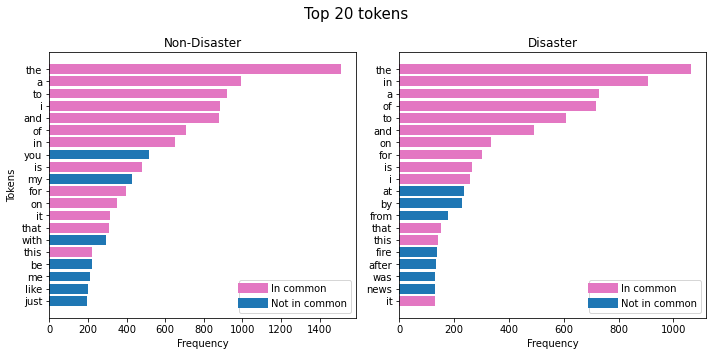

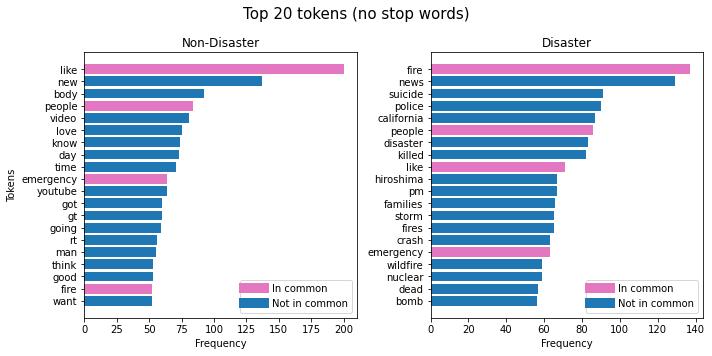

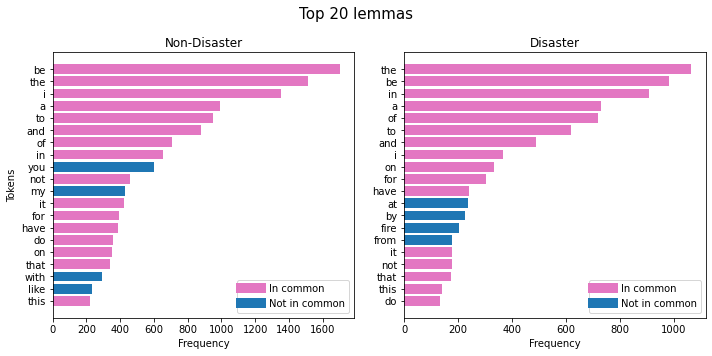

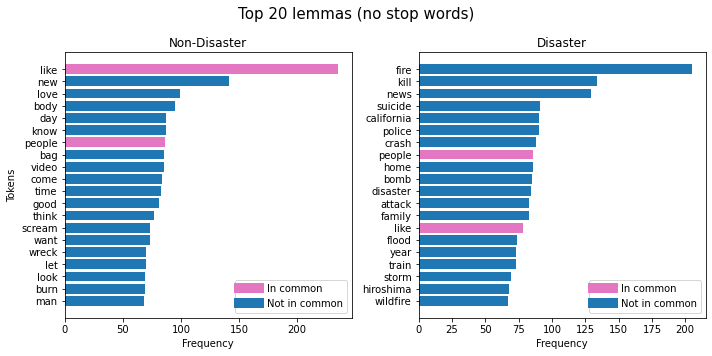

In [111]:
plot_freqdict_classes(X_train['tokens'], y_train, 'tokens')
plot_freqdict_classes(X_train['tokens_no_sw'], y_train, 'tokens (no stop words)')
plot_freqdict_classes(X_train['lemmas'], y_train, 'lemmas')
plot_freqdict_classes(X_train['lemmas_no_sw'], y_train, 'lemmas (no stop words)')

I can tell from the charts above the version of tweets that are the most different in terms of token frequency is the **lemmatized tweets with no stop words.** In the top 20 tokens from each class, there are only two shared tokens. In contrast, if stop words are not removed, most tokens are shared between classes.

#### This will be useful when deciding which version of the tokenized tweets I will vectorize, in order to feed into the models.

### More linguistic feature engineering

I will use the SpaCy library to extract more linguistic features from the tweets.

### Vectorized part of speech (POS) tags

The SpaCy library is pre-trained to parse through sentences and identify each word's grammatical part of speech.

Here are some examples of what the tool can identify:

In [56]:
pos_samples = X_train['text'].loc[[5905, 4355, 7119, 7312, 3143]]
pos_samples = pos_samples.apply(lambda x: nlp(x).sents)
pos_samples = pos_samples.apply(lambda x: [s.text for s in x])
pos_samples = pos_samples.apply(lambda x: [tokenizer.tokenize(s) for s in x])
pos_samples = pos_samples.apply(lambda x: [' '.join(s) for s in x])
pos_samples = pos_samples.apply(lambda x: '. '.join(x))

options_displacy_pos = {'compact':True, 'distance':90, 'bg':'#3056ff', 'color':'fff'}

for idx in pos_samples.index:
    print(pos_samples.loc[idx])
    displacy.render(nlp(pos_samples.loc[idx]), style='dep', jupyter=True, options=options_displacy_pos)     

watch this airport get swallowed up by a sandstorm in under a minute


governor allows parole for california school bus hijacker who kidnapped children in. 


a brief violent storm swept through the chicago area sunday afternoon leading to one death and an evacuation of lollapalooza and more


firefighters from connecticut are headed to california to fight wild fires


plane from new york to kuwait diverts to uk after declaring state of emergency


I plan to use this SpaCy tool in order to vectorize the detailed [parts of speech](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html) of each tweet.

First, I'll convert each token into a string of its POS tag.

In [57]:
# Spacy POS

def spacy_pos(text):
    """
    Takes in a string and returns a list of part of speech tokens.
    """
    sents = [s.text for s in nlp(text).sents]
    sents_tokenized = [tokenizer.tokenize(sent) for sent in sents]
    docs = [nlp(' '.join(tokens)) for tokens in sents_tokenized]
    pos_tokens = [[t.pos_ for t in doc] for doc in docs]
    return list(itertools.chain.from_iterable(pos_tokens))

# Testing the function on a sample
X_train['text'].sample(10, random_state=seed).apply(spacy_pos)

4410                                                                [NOUN, NOUN, ADP, PROPN, PROPN, ADP, ADP, PROPN, PROPN, PROPN, PROPN, NOUN]
2661                                                                                                      [DET, PROPN, PROPN, ADJ, NOUN, PROPN]
2899                                                                                                [PROPN, ADV, SCONJ, VERB, PRON, VERB, PRON]
1608                                       [PROPN, PROPN, PROPN, PART, NOUN, NOUN, VERB, SCONJ, NOUN, NOUN, VERB, SCONJ, NOUN, VERB, ADP, VERB]
2756    [VERB, INTJ, PRON, VERB, CCONJ, PRON, AUX, DET, NOUN, NOUN, PRON, VERB, NOUN, ADP, SCONJ, PRON, ADV, VERB, NOUN, ADV, PRON, VERB, PRON]
5086                                     [SCONJ, ADJ, ADJ, NOUN, VERB, ADP, PROPN, PROPN, NOUN, NOUN, AUX, ADV, ADJ, ADP, PRON, ADJ, ADJ, NOUN]
7441                     [PRON, AUX, ADV, ADV, ADJ, NOUN, PRON, ADV, VERB, PART, VERB, PRON, VERB, PRON, NOUN, PRON, PRON, ADV, VERB, AU

In order to make the POS vectors, I'm using scikit-learn's CountVectorizer in a slightly unorthodox way. I'm using it to count POS tags rather than tokens.

In [58]:
# Making dataframes of vectorized POS tags

pos_vectorizer = CountVectorizer(tokenizer=spacy_pos)
pos_vec_train = pos_vectorizer.fit_transform(X_train['text'])
pos_vec_df_train = pd.DataFrame(
        pos_vec_train.toarray(),
        columns=pos_vectorizer.get_feature_names_out(),
        index=X_train.index
)

In [59]:
pos_vec_df_train.head()

,ADJ,ADP,ADV,AUX,CCONJ,DET,INTJ,NOUN,NUM,PART,PRON,PROPN,PUNCT,SCONJ,VERB,X
39,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0
418,2,0,1,0,0,1,0,2,0,0,0,0,0,0,2,0
4916,1,1,2,1,0,0,0,0,0,1,2,0,0,0,2,0
2126,3,2,0,1,2,1,0,7,0,0,6,0,0,0,1,0
1054,0,0,1,0,0,0,0,3,0,0,0,0,0,0,2,0


This matrix of parts-of speech will hopefully be useful to the model, but I can take it even further. I'm going to look at disparities in the proportions of POS tags between each class.

In [60]:
pos_vec_df_norm_train = pos_vec_df_train.div(pos_vec_df_train.sum(axis=1), axis=0)
pos_vec_df_norm_train.columns = pos_vec_df_train.columns + '_norm'
pos_vec_df_norm_train.head()

,ADJ_norm,ADP_norm,ADV_norm,AUX_norm,CCONJ_norm,DET_norm,INTJ_norm,NOUN_norm,NUM_norm,PART_norm,PRON_norm,PROPN_norm,PUNCT_norm,SCONJ_norm,VERB_norm,X_norm
39,0.250000,0.250000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.25000,0.25,0.0,0.0,0.000000,0.0
418,0.250000,0.000000,0.125000,0.000000,0.000000,0.125000,0.0,0.250000,0.0,0.0,0.00000,0.00,0.0,0.0,0.250000,0.0
4916,0.100000,0.100000,0.200000,0.100000,0.000000,0.000000,0.0,0.000000,0.0,0.1,0.20000,0.00,0.0,0.0,0.200000,0.0
2126,0.130435,0.086957,0.000000,0.043478,0.086957,0.043478,0.0,0.304348,0.0,0.0,0.26087,0.00,0.0,0.0,0.043478,0.0
1054,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.0,0.500000,0.0,0.0,0.00000,0.00,0.0,0.0,0.333333,0.0


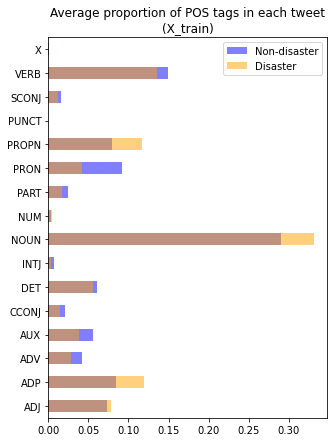

In [61]:
fig, ax = plt.subplots(figsize=(5,7))
fig.set_facecolor('white')
pos_plot_0 = pos_vec_df_norm_train[y_train==0].mean().plot(
    kind='barh',
    ax=ax,
    color='blue', alpha=0.5,
    label='Non-disaster'
)
pos_plot_1 = pos_vec_df_norm_train[y_train==1].mean().plot(
    kind='barh',
    ax=ax,
    color='orange', alpha=0.5,
    label='Disaster'
)
ax.set_title('Average proportion of POS tags in each tweet\n(X_train)')
ax.set_yticklabels(pos_vec_df_train.columns)
ax.legend()
# plt.savefig('./images/pos_rates.png', dpi=500)
plt.show()

Between the two classes, there are noticeable disparities with the following POS tags:

* ADP: adposition
* ADV: adverb
* AUX: auxiliary
* NOUN: Noun
* PRON: Pronoun
* PROPN: Proper noun

In [62]:
interesting_tags = ['ADP_norm', 'ADV_norm', 'AUX_norm', 'NOUN_norm', 'PRON_norm', 'PROPN_norm']

pos_vec_df_train = pos_vec_df_train.join(pos_vec_df_norm_train[interesting_tags])

In [63]:
pos_vec_df_train.head()

,ADJ,ADP,ADV,AUX,CCONJ,DET,INTJ,NOUN,NUM,PART,...,PUNCT,SCONJ,VERB,X,ADP_norm,ADV_norm,AUX_norm,NOUN_norm,PRON_norm,PROPN_norm
39,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0.250000,0.000000,0.000000,0.000000,0.25000,0.25
418,2,0,1,0,0,1,0,2,0,0,...,0,0,2,0,0.000000,0.125000,0.000000,0.250000,0.00000,0.00
4916,1,1,2,1,0,0,0,0,0,1,...,0,0,2,0,0.100000,0.200000,0.100000,0.000000,0.20000,0.00
2126,3,2,0,1,2,1,0,7,0,0,...,0,0,1,0,0.086957,0.000000,0.043478,0.304348,0.26087,0.00
1054,0,0,1,0,0,0,0,3,0,0,...,0,0,2,0,0.000000,0.166667,0.000000,0.500000,0.00000,0.00


In [64]:
time_check()

Time check: 5 minutes and 45 seconds


### Vectorized named-entity recognition (NER) tags 
SpaCy also has the capability of recognizing "named-entities" such as places, companies, dates, people, and more. Here are some examples of what the tool can identify.

In [65]:
# X_train['text'][(ner_vec_df_train['GPE'] > 0) & (ner_vec_df_train['ORG'] > 0)].sample(3)

In [66]:
ner_samples = X_train['text'].loc[[5642, 2945, 7119, 7312, 6428]]
ner_samples = ner_samples.apply(lambda x: nlp(x).sents)
ner_samples = ner_samples.apply(lambda x: [s.text for s in x])
ner_samples = ner_samples.apply(lambda x: [tokenizer.tokenize(s) for s in x])
ner_samples = ner_samples.apply(lambda x: [' '.join(s) for s in x])
ner_samples = ner_samples.apply(lambda x: '. '.join(x))

for idx in ner_samples.index:
    displacy.render(nlp(ner_samples.loc[idx]), style='ent', jupyter=True)

For the purposes of identifying disaster tweets, here are the [NER tags](https://towardsdatascience.com/explorations-in-named-entity-recognition-and-was-eleanor-roosevelt-right-671271117218) I am interested in:

* **GPE**: Countries, cities, states.
* **LOC**: Non-GPE locations, mountain ranges, bodies of water.
* **NORP**: Nationalities or religious or political groups.
* **ORG**: Companies, agencies, institutions, etc.

I am again using scikit-learn's CountVectorizer to count the entities that SpaCy finds in each tweet.

In [67]:
# Spacy NER

def spacy_ner(
    text, 
    ner_tags=['GPE', 'NORP', 'ORG', 'LOC']
    ):
    """
    Takes in a string and returns a list of named-entity recognition tags.
    Also takes in a specific list of NER tags to look for.
    To look for all NER tags supported by SpaCy, set `ner_tags=None`.
    Intended use is to use this function as a tokenizer in an sklearn vectorizor.
    """
    tokens = tokenizer.tokenize(text)
    doc = nlp(' '.join(tokens))
    ents = doc.ents
    if ner_tags:
        tags = [ent.label_ for ent in ents if ent.label_ in ner_tags]
        return tags
    else:
        tags = [ent.label_ for ent in ents]
        return tags

In [68]:
# Making dataframes of vectorized NER tags

ner_vectorizer = CountVectorizer(tokenizer=spacy_ner)
ner_vec_train = ner_vectorizer.fit_transform(X_train['text'])
ner_vec_df_train = pd.DataFrame(
        ner_vec_train.toarray(),
        columns=ner_vectorizer.get_feature_names_out(),
        index=X_train.index
)

In [69]:
ner_vec_df_train.head()

,GPE,LOC,NORP,ORG
39,0,0,0,0
418,0,0,0,0
4916,0,0,0,0
2126,0,0,0,0
1054,0,0,0,0


In [70]:
time_check()

Time check: 6 minutes and 39 seconds


### Using NER to encode the `location` column

As noted earlier, the `location` column contains a lot of user-generated nonsense.

In [71]:
print('Sample of some of the location values')
df['location'].unique()[7:17].tolist()

Sample of some of the location values


['World Wide!!',
 'Paranaque City',
 'milky way',
 'GREENSBORO,NORTH CAROLINA',
 'England.',
 'Sheffield Township, Ohio',
 'India',
 'Barbados',
 'Anaheim',
 'Abuja']

But some of its data may be genuine. I can use named-entity recognition to discern if an entry is referring to an actual location. 

In [72]:
# Find any NER tags in the location column

location_NER_train = X_train['location'].apply(lambda x: [ent.label_ for ent in nlp(x).ents])
location_NER_train.head()

39           [GPE]
418             []
4916    [GPE, ORG]
2126            []
1054         [ORG]
Name: location, dtype: object

In [73]:
# Binarize based on if the location returns a GPE tag (countries, cities, states)
# Add this new feature to the NER training set 

ner_vec_df_train['location_GPE'] = location_NER_train.apply(lambda x: int('GPE' in x))
ner_vec_df_train.head()

,GPE,LOC,NORP,ORG,location_GPE
39,0,0,0,0,1
418,0,0,0,0,0
4916,0,0,0,0,1
2126,0,0,0,0,0
1054,0,0,0,0,0


In [74]:
time_check()

Time check: 7 minutes and 21 seconds


## Meta-feature Engineering

To engineer more features, I'm going to use seemingly arbitrary information from each tweet. Here's the set of meta-features I plan to make:

* Has URL (binary)
* Character count
* Number of stop words
* Character count of non-stop words divided by total character count
* Average length of tokens
* Number of tokens
* Number of unique tokens
* Proportion of stop words
* Proportion of words that are hashtags (#)
* Proportion of words that are mentions (@)

I drew inspiration for some of these features from [this Kaggle entry](https://www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert/notebook).

With the meta-features that are token-oriented, I have an option of four different versions of tokenized tweets:

* tokens
* tokens without stop words
* lemmas
* lemmas without stop words

I'm primarily using `lemmas_no_sw` (lemmatized tweets with stop words removed) because that version looked the most different between classes in the previous visualization.

Making a new DataFrame composed of the meta-features I listed above:

In [78]:
# has_url_Series already exists
# Start a DF with it

meta_features_df_train = pd.DataFrame(has_url_Series_train)

# Character count. Original tweet. No URL.
meta_features_df_train['character_count'] = \
    X_train['text'].apply(len)

# Stop word count. Original tweet. No URL.
meta_features_df_train['sw_count'] = \
    X_train['tokens'].apply(lambda x: len([w for w in x if w in stopword_list]))

# Character count of non-stop-words / original character count. No URL.
meta_features_df_train['non_sw_char_proportion'] = \
    X_train['tokens_no_sw'].apply(lambda x: len(''.join(x))) / X_train['text'].apply(len)

# Average lemma length. Including stop words.
meta_features_df_train['mean_lemma_length'] = \
    X_train['lemmas'].apply(lambda x: np.mean([len(l) for l in x]))

# Lemma count. No stop words.
meta_features_df_train['lemma_count_no_sw'] = \
    X_train['lemmas_no_sw'].apply(len)

# Number of unique lemmas. No stop words.
meta_features_df_train['unique_lemmas_no_sw'] = \
    X_train['lemmas_no_sw'].apply(lambda x: len(set(x)))

# Proportion of stop words
meta_features_df_train['sw_proportion'] = \
    X_train['tokens'].apply(lambda x: len([w for w in x if w in stopword_list]))\
        / X_train['tokens'].apply(len)

# Proportion of hashtags
meta_features_df_train['hashtag_proportion'] = \
    X_train['text'].apply(lambda x: len(re.findall(r'#{1}\w+', x)))\
        / X_train['tokens'].apply(len)

# Proportion of mentions
meta_features_df_train['mention_proportion'] = \
    X_train['text'].apply(lambda x: len(re.findall(r'@{1}\w+', x)))\
        / X_train['tokens'].apply(len)

meta_features_df_train.head()

,has_url,character_count,sw_count,non_sw_char_proportion,mean_lemma_length,lemma_count_no_sw,unique_lemmas_no_sw,sw_proportion,hashtag_proportion,mention_proportion
39,0,22,2,0.454545,4.000000,2,2,0.500000,0.0,0.00
418,0,59,2,0.711864,6.125000,6,6,0.250000,0.0,0.25
4916,0,44,6,0.409091,3.200000,4,4,0.600000,0.0,0.00
2126,0,144,13,0.416667,4.260870,10,9,0.565217,0.0,0.00
1054,0,35,1,0.685714,3.833333,4,4,0.166667,0.0,0.00


In [79]:
kwargs_histplot = {'kde':True, 'stat':"density", 'linewidth':0, 'bins':20}

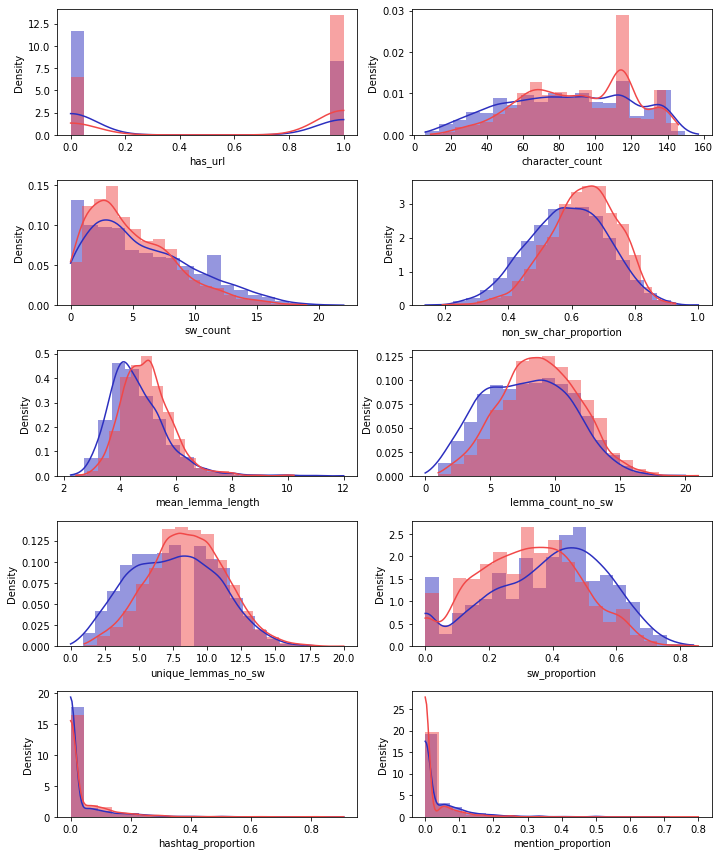

In [80]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10,12))
fl_ax = axes.flatten()
fig.set_facecolor('white')
for idx, ftr in list(enumerate(meta_features_df_train.columns)):
    sns.histplot(meta_features_df_train[ftr][y_train==0], ax=fl_ax[idx], **kwargs_histplot, color=color_non)
    sns.histplot(meta_features_df_train[ftr][y_train==1], ax=fl_ax[idx], **kwargs_histplot, color=color_disaster)

plt.tight_layout()
# plt.savefig('./images/meta_features_basic.png', dpi=500)
plt.show()

The density plots above show that some of the meta-features I engineered have different distributions when separated by target class. Hopefully this provides more signal for the model.

In [81]:
time_check()

Time check: 7 minutes and 28 seconds


## Vectorizing the tweets

I've engineered linguistic features and meta-features. Now I'm going to make the actual text of the tweets interpretable by a machine learning model using [scikit-learn's TF-IDF vectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). This vectorizer returns the [**term frequency-inverse document frequency**](https://towardsdatascience.com/tf-idf-for-document-ranking-from-scratch-in-python-on-real-world-dataset-796d339a4089) (TF-IDF) of each token in each tweet.

TF-IDF is a measurement that takes into account the 1) token's frequency within the tweet and (term frequency) 2) how rare it is for the token to appear in a tweet (inverse document frequency). 

I'm using the lemmatized version of tweets with stop words removed. Recall that this is the version that looked the most different between classes when I graphed token frequencies earlier. The vectorizer will return TF-IDF values for the top 500 frequently occurring lemmas across the "corpus" -- which is the collection of tweets.

In [82]:
tfidf = TfidfVectorizer(
    tokenizer=spacy_lemmatize, 
    stop_words=stopword_list_lem,
    max_features=500
    )

X_train_vec = tfidf.fit_transform(X_train['text'])

X_train_vec_df = pd.DataFrame(
    X_train_vec.toarray(),
    columns=tfidf.get_feature_names_out(),
    index=X_train.index
    )
X_train_vec_df.head()

,abc,ablaze,accident,actually,affect,ago,air,airplane,airport,ambulance,...,work,world,wound,wreck,wreckage,yeah,year,youtube,yr,zone
39,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
418,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4916,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2126,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1054,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Finally, I'm going to combine the vectors with the other features I've engineered so far into a single DataFrame. All features are being scaled, as well.

**This is the DataFrame that the model will train on.**

In [83]:
X_train_combined_df = pd.concat(
    [
        X_train_vec_df,
        pos_vec_df_train, 
        ner_vec_df_train, 
        meta_features_df_train,
    ],
    axis=1
    )

# Scaling all features

scaler = StandardScaler()
X_train_combined_df_scaled = scaler.fit_transform(X_train_combined_df)
X_train_combined_df_scaled = pd.DataFrame(X_train_combined_df_scaled, index=X_train.index, columns=X_train_combined_df.columns)

X_train_combined_df_scaled.head()

,abc,ablaze,accident,actually,affect,ago,air,airplane,airport,ambulance,...,has_url,character_count,sw_count,non_sw_char_proportion,mean_lemma_length,lemma_count_no_sw,unique_lemmas_no_sw,sw_proportion,hashtag_proportion,mention_proportion
39,-0.063712,24.039418,-0.106811,-0.062105,-0.073456,-0.063024,-0.078158,-0.064788,-0.066128,-0.075068,...,-1.056584,-2.000603,-0.860117,-1.251505,-0.779544,-1.913161,-1.935395,0.799326,-0.391792,-0.443234
418,-0.063712,-0.060391,-0.106811,-0.062105,-0.073456,-0.063024,-0.078158,-0.064788,-0.066128,-0.075068,...,-1.056584,-0.862925,-0.860117,0.841910,1.341708,-0.681589,-0.639648,-0.605410,-0.391792,3.116885
4916,-0.063712,-0.060391,-0.106811,-0.062105,-0.073456,-0.063024,-0.078158,-0.064788,-0.066128,-0.075068,...,-1.056584,-1.324146,0.149080,-1.621299,-1.578133,-1.297375,-1.287522,1.361221,-0.391792,-0.443234
2126,-0.063712,-0.060391,-0.106811,-0.062105,-0.073456,-0.063024,-0.078158,-0.064788,-0.066128,-0.075068,...,-1.056584,1.750658,1.915175,-1.559667,-0.519134,0.549983,0.332162,1.165779,-0.391792,-0.443234
1054,-0.063712,-0.060391,-0.106811,-0.062105,-0.073456,-0.063024,-0.078158,-0.064788,-0.066128,-0.075068,...,-1.056584,-1.600878,-1.112416,0.629166,-0.945916,-1.297375,-1.287522,-1.073655,-0.391792,-0.443234


In [84]:
time_check()

Time check: 9 minutes and 46 seconds


#### Apply all pre-processing steps to test and validation sets.
The function below runs the `test` and `val` sets through the exact same preprocessing steps that the `train` set as undergone.

By default, the function makes use of the exact transformer objected that have been trained on `X_train`, in order to avoid data leakage.

In [85]:
def preprocess_tweets(
    df_to_process,
    tokenizer=tokenizer,
    stop_words=stopword_list, 
    lemmatizer=spacy_lemmatize,
    stop_words_lem=stopword_list_lem,
    trained_pos_vectorizer=pos_vectorizer,
    trained_ner_vectorizer=ner_vectorizer,
    trained_word_vectorizer=tfidf,
    trained_scaler=scaler,
    return_scaled=True,
    return_cleaned=False
):
    index=df_to_process.index
    tweet_df = df_to_process.copy()

    tweet_df['location'] = tweet_df['location'].fillna('location_missing')

    tweet_df['text'] = tweet_df['text'].apply(lambda x: x.lower())
    has_url_Series = tweet_df['text'].apply(binary_url).rename('has_url')
    tweet_df['has_url'] = has_url_Series
    tweet_df['text'] = \
        tweet_df['text'].apply(lambda x: re.sub(pattern=r'http\S+', repl='', string=x))

    tweet_df['text'] = tweet_df['text'].apply(lambda x: re.sub("&amp;", "and", x))
    tweet_df['tokens'] = tweet_df['text'].apply(tokenizer.tokenize)
    tweet_df['tokens_no_sw'] = \
        tweet_df['tokens'].apply(lambda x: [w for w in x if not w in stop_words])

    tweet_df['lemmas'] = tweet_df['text'].apply(lemmatizer)
    tweet_df['lemmas_no_sw'] = \
        tweet_df['lemmas'].apply(lambda x: [l for l in x if l not in stop_words_lem])

    pos_vec = trained_pos_vectorizer.transform(tweet_df['text'])
    pos_vec_df = pd.DataFrame(
        pos_vec.toarray(), 
        columns=trained_pos_vectorizer.get_feature_names_out(),
        index=index
    )
    pos_vec_df_norm = pos_vec_df.div(pos_vec_df.sum(axis=1), axis=0)
    pos_vec_df_norm.columns = pos_vec_df.columns + '_norm'
    interesting_tags = ['ADP_norm', 'ADV_norm', 'AUX_norm', 'NOUN_norm', 'PRON_norm', 'PROPN_norm']
    pos_vec_df = pos_vec_df.join(pos_vec_df_norm[interesting_tags])

    ner_vec = trained_ner_vectorizer.transform(tweet_df['text'])
    ner_vec_df = pd.DataFrame(
        ner_vec.toarray(),
        columns=trained_ner_vectorizer.get_feature_names_out(),
        index=index
    )
    ner_vec_df['location_GPE'] = tweet_df['location'].apply(lambda x: int('GPE' in [ent.label_ for ent in nlp(x).ents]))

    meta_features_df = pd.DataFrame(has_url_Series)
    # Character count. Original tweet. No URL.
    meta_features_df['character_count'] = \
        tweet_df['text'].apply(len)
    # Stop word count. Original tweet. No URL.
    meta_features_df['sw_count'] = \
        tweet_df['tokens'].apply(lambda x: len([w for w in x if w in stop_words]))
    # Character count of non-stop-words / original character count. No URL.
    meta_features_df['non_sw_char_proportion'] = \
        tweet_df['tokens_no_sw'].apply(lambda x: len(''.join(x))) / tweet_df['text'].apply(len)
    # Average lemma length. Including stop words.
    meta_features_df['mean_lemma_length'] = \
        tweet_df['lemmas'].apply(lambda x: np.mean([len(l) for l in x]))
    # Lemma count. No stop words.
    meta_features_df['lemma_count_no_sw'] = \
        tweet_df['lemmas_no_sw'].apply(len)
    # Number of unique lemmas. No stop words.
    meta_features_df['unique_lemmas_no_sw'] = \
        tweet_df['lemmas_no_sw'].apply(lambda x: len(set(x)))
    # Proportion of stop words
    meta_features_df['sw_proportion'] = \
        tweet_df['tokens'].apply(lambda x: len([w for w in x if w in stop_words]))\
            / tweet_df['tokens'].apply(len)\
    # Proportion of hashtags
    meta_features_df['hashtag_proportion'] = \
        tweet_df['text'].apply(lambda x: len(re.findall(r'#{1}\w+', x)))\
            / tweet_df['tokens'].apply(len)
    # Proportion of mentions
    meta_features_df['mention_proportion'] = \
        tweet_df['text'].apply(lambda x: len(re.findall(r'@{1}\w+', x)))\
            / tweet_df['tokens'].apply(len)

    tweets_vec = trained_word_vectorizer.transform(tweet_df['text'])
    tweets_vec_df = pd.DataFrame(
        tweets_vec.toarray(), 
        columns=trained_word_vectorizer.get_feature_names_out(),
        index=index
    )
    tweets_combined_df = pd.concat(
        [
            tweets_vec_df,
            pos_vec_df,
            ner_vec_df,
            meta_features_df
        ],
        axis=1
    )
    tweets_combined_df_scaled = trained_scaler.transform(tweets_combined_df)
    tweets_combined_df_scaled = pd.DataFrame(
        tweets_combined_df_scaled, 
        index=index, 
        columns=tweets_combined_df.columns
        )

    if return_scaled:
        if return_cleaned:
            return {'processed':tweets_combined_df_scaled, 'cleaned':tweet_df}
        else:
            return tweets_combined_df_scaled
    else:
        if return_cleaned:
            return {'processed':tweets_combined_df, 'cleaned':tweet_df}
        else:
            return tweets_combined_df

In [86]:
X_test_combined_df_scaled = preprocess_tweets(X_test)
X_val_combined_df_scaled = preprocess_tweets(X_val)

In [87]:
time_check()

Time check: 11 minutes and 55 seconds


## Modeling

In this section I'll begin using Keras to make neural networks to predict disaster tweets.

This will be an iterative process where I'll tweak various parameters and hyperparameters while monitoring each model's optimization and performance. Models will be judged based on performance with the validation dataset (X_val). 

I'm using the stochastic gradient descent (SGD) algorithm to optimize each model, aiming to minimize logarithmic loss, or binary cross entropy. This is mainly to monitor for things like overfitting, underfitting, and convergence. Models will be configured to automatically stop when the loss on the validation set hasn't improved in 20 epochs.

Ultimately, however the model with the best recall score will be selected, given that there aren't over or underfitting issues. This is not necessarily the model with the lowest loss. Recall is the most intuitive and relevant metric to present to the stakeholder, as the stakeholder needs to reduce false negatives (i.e. disaster tweets that are neglected by the newsroom).

For each model, I'll plot performance for commonly used metrics (accuracy, precision, recall, F1, AUROC). This is to make sure there are no red flags despite, say, a decent recall score (*A model that predicts that every tweet is in class 1 will have a perfect recall score but abysmal accuracy!*).

After selecting a model, it will be given a final recall score using the test set (X_test).

By default, Keras does not have a scorer for F1, as it does with accuracy, recall, and others. I will define the F1 scorer myself, using instructions from this [blog post](https://aakashgoel12.medium.com/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d).

In [88]:
import tensorflow.keras.backend as Kb

def K_f1(y_true, y_pred):
    true_positives = Kb.sum(Kb.round(Kb.clip(y_true * y_pred, 0, 1)))
    possible_positives = Kb.sum(Kb.round(Kb.clip(y_true, 0, 1)))
    predicted_positives = Kb.sum(Kb.round(Kb.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + Kb.epsilon())
    recall = true_positives / (possible_positives + Kb.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+Kb.epsilon())
    return f1_val

# Defining scorers for Keras models

precision = Precision()
recall = Recall()
auc = AUC()
f1 = K_f1

In [89]:
# Defining a function to visualize neural network performance

def plot_nn_curves(model_history):

    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18,12))
    fl_ax = axes.flatten()
    for idx, metric in enumerate(['loss', 'accuracy', 'precision', 'recall', 'auc', 'f1']):
        pair = [m for m in model_history.history.keys() if metric in m]
        fl_ax[idx].plot(model_history.history[pair[0]], label=metric)
        fl_ax[idx].plot(model_history.history[pair[1]], label=metric+'_val')
        fl_ax[idx].set_xlabel('epochs')
        fl_ax[idx].set_ylabel(metric)
        fl_ax[idx].set_title(f'{metric.upper()} Evaluation')
        fl_ax[idx].legend()
        plt.tight_layout();

In [90]:
n_input = X_train_combined_df_scaled.shape[1]
n_input

537

### Baseline model
The baseline model will have one hidden layer with half as many nodes as there are input features.

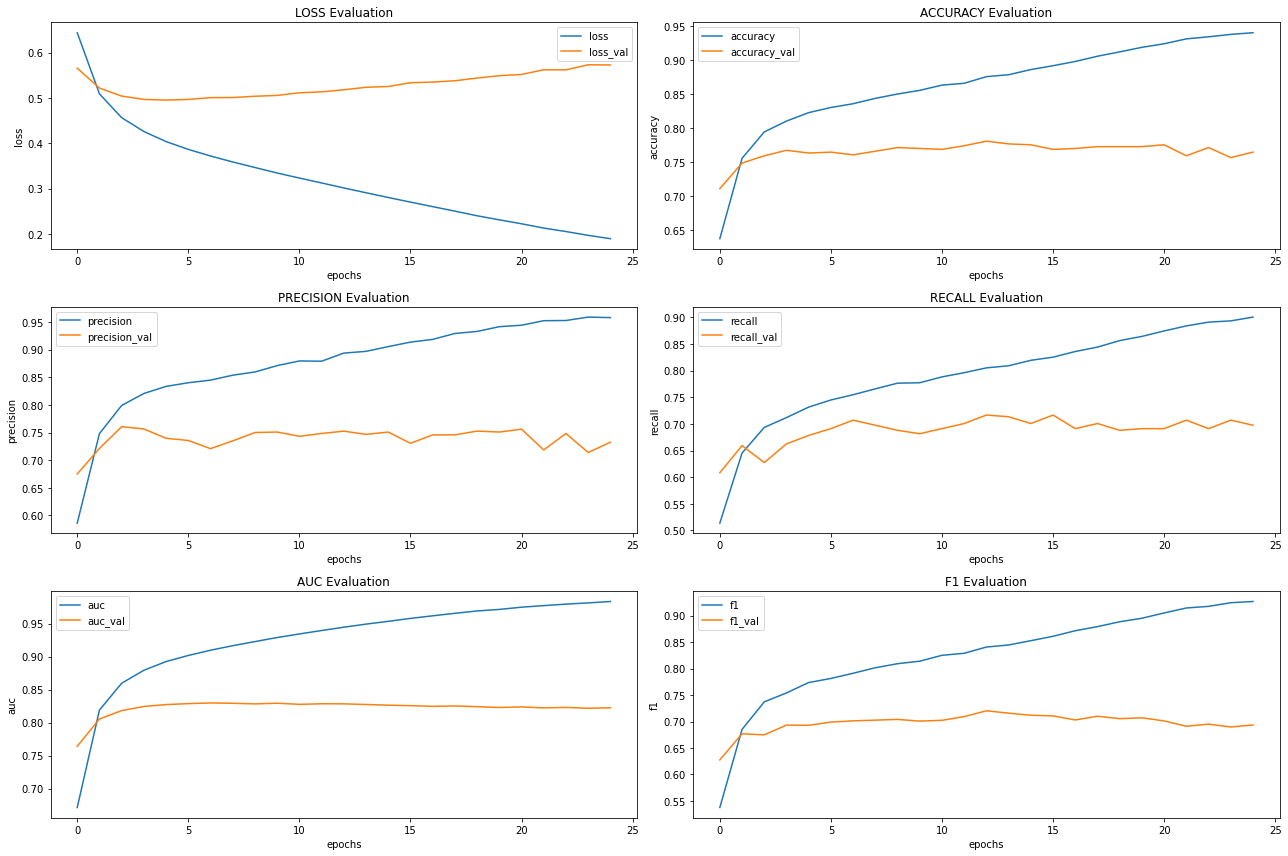

In [91]:
# Baseline with one hidden layer

set_seed(seed)

model_baseline = models.Sequential()

model_baseline.add(layer=layers.Dense(
    units=round(n_input/2),
    activation='relu',
    input_shape=(n_input,)
))

model_baseline.add(layer=layers.Dense(
    units=1,
    activation='sigmoid',
))

model_baseline.compile(
    optimizer=SGD(),
    loss='binary_crossentropy',
    metrics=['accuracy', precision, recall, auc, f1]
)

early_stopping = [
    EarlyStopping(monitor='val_loss', patience=20)
    ]

model_hist_baseline = model_baseline.fit(
    np.array(X_train_combined_df_scaled),
    np.array(y_train),
    epochs=150,
    batch_size=32,
    validation_data=(X_val_combined_df_scaled, y_val),
    verbose=False,
    callbacks=early_stopping
)

plot_nn_curves(model_hist_baseline)

In [92]:
model_baseline.evaluate(X_val_combined_df_scaled, y_val, return_dict=True)

24/24 [==============================] - 0s 1ms/step - loss: 0.5729 - accuracy: 0.7648 - precision: 0.7324 - recall: 0.6975 - auc: 0.8226 - K_f1: 0.6934


{'loss': 0.5728746652603149,
 'accuracy': 0.7647849321365356,
 'precision': 0.7324414849281311,
 'recall': 0.6974522471427917,
 'auc': 0.8225670456886292,
 'K_f1': 0.6934359669685364}

#### Baseline model validation results:
* Loss: 0.5729
* Recall: 0.6975
* There is clear overfitting. The validation loss diverges strongly from the training loss within a few epochs.
___

### Model 1
Changes: Add L2 (ridge) regularization to the hidden layer.

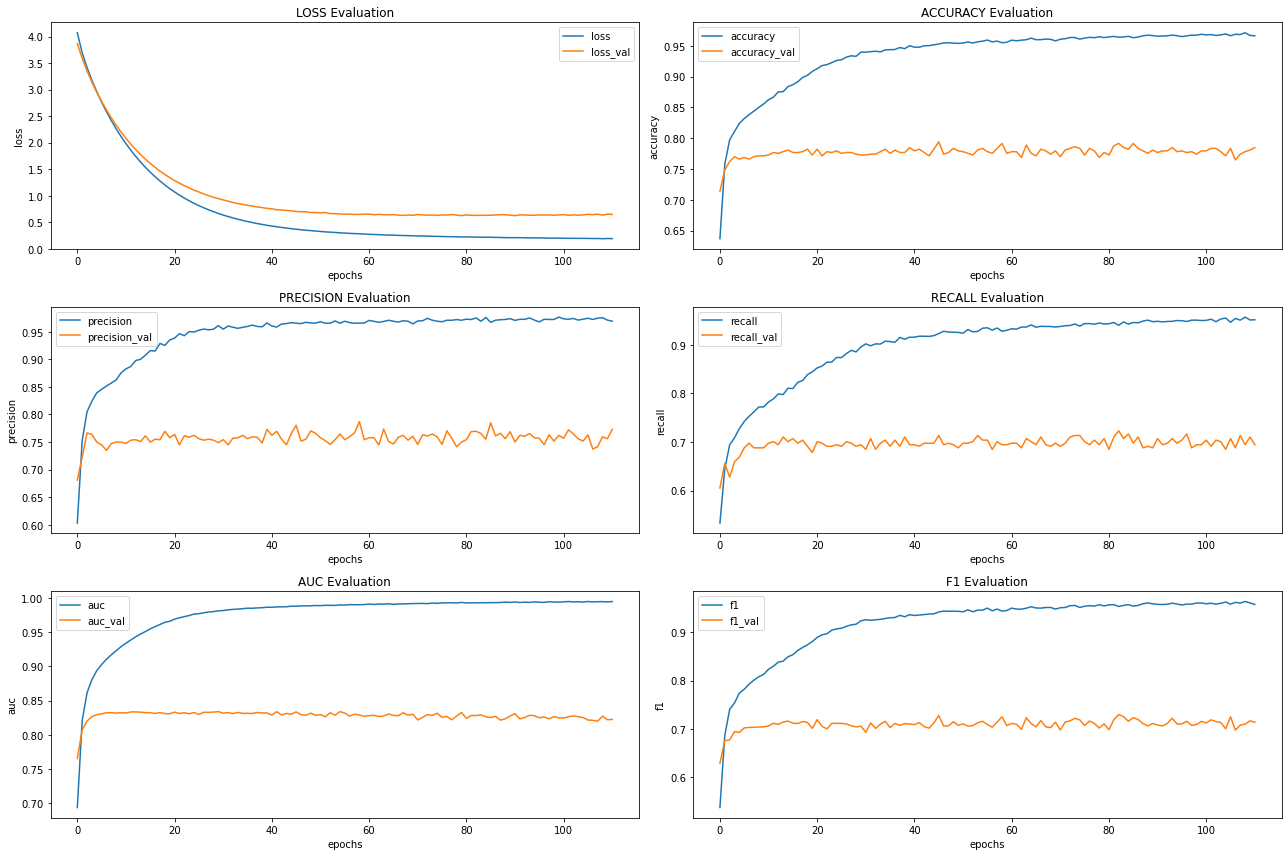

In [93]:
# Add regularization

set_seed(seed)

model_1 = models.Sequential()

model_1.add(layer=layers.Dense(
    units=round(n_input/2),
    activation='relu',
    input_shape=(n_input,),
    kernel_regularizer=regularizers.L2()
))

model_1.add(layer=layers.Dense(
    units=1,
    activation='sigmoid',
))

model_1.compile(
    optimizer=SGD(),
    loss='binary_crossentropy',
    metrics=['accuracy', precision, recall, auc, f1]
)

early_stopping = [
    EarlyStopping(monitor='val_loss', patience=20)
    ]

model_hist_1 = model_1.fit(
    np.array(X_train_combined_df_scaled),
    np.array(y_train),
    epochs=150,
    batch_size=32,
    validation_data=(X_val_combined_df_scaled, y_val),
    verbose=False,
    callbacks=early_stopping
)

plot_nn_curves(model_hist_1)

In [94]:
model_1.evaluate(X_val_combined_df_scaled, y_val, return_dict=True)

24/24 [==============================] - 0s 2ms/step - loss: 0.6467 - accuracy: 0.7849 - precision: 0.7730 - recall: 0.6943 - auc: 0.8224 - K_f1: 0.7137


{'loss': 0.6466742753982544,
 'accuracy': 0.7849462628364563,
 'precision': 0.7730496525764465,
 'recall': 0.6942675113677979,
 'auc': 0.8223782181739807,
 'K_f1': 0.713716983795166}

#### Model 1 validation results
* Loss: 0.6467
* Recall: 0.6943
* Performance is slightly worse than before, but overfitting is more under control.
___

### Model 2
Changes: Tweak regularization factor from default (0.01) to 0.05.

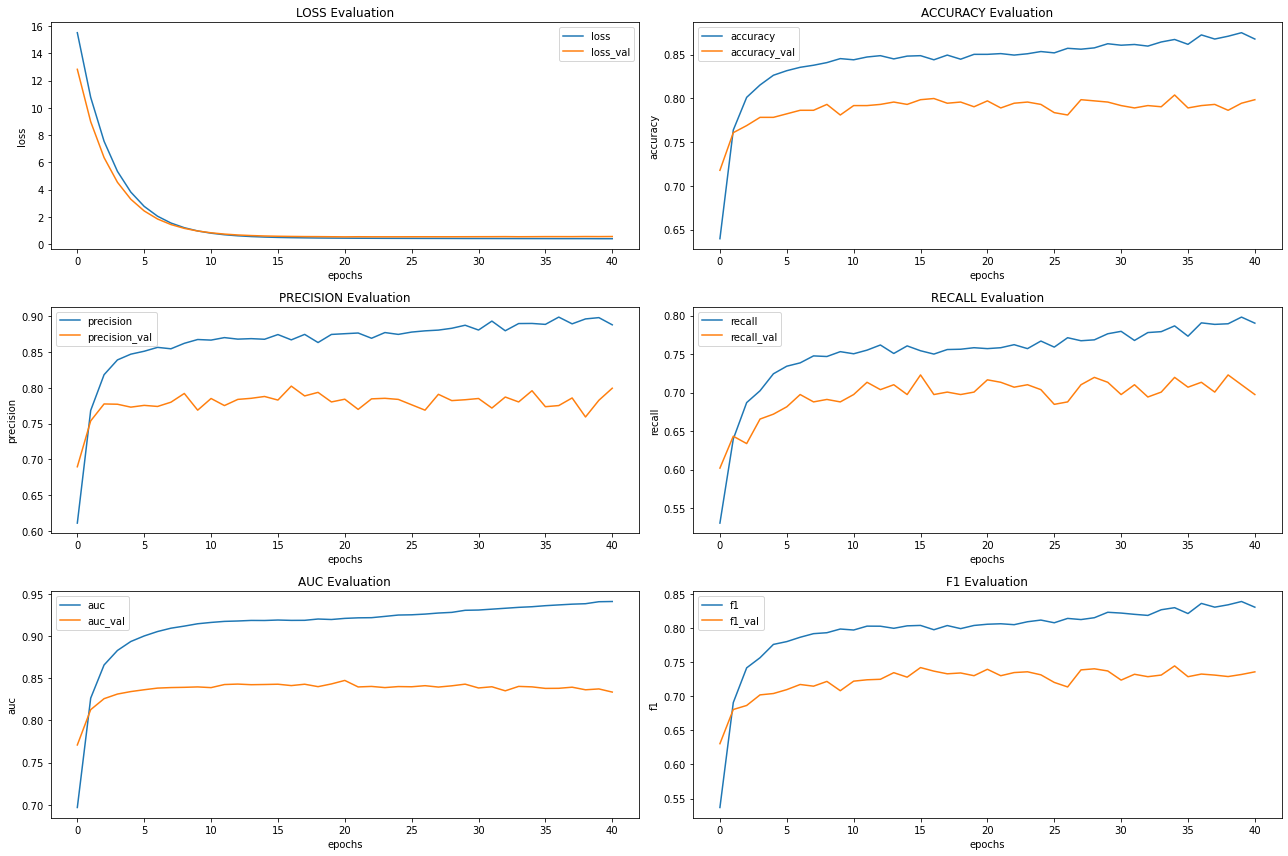

In [95]:
# Tweak regularization

set_seed(seed)

model_2 = models.Sequential()

model_2.add(layer=layers.Dense(
    units=round(n_input/2),
    activation='relu',
    input_shape=(n_input,),
    kernel_regularizer=regularizers.L2(0.05)
))

model_2.add(layer=layers.Dense(
    units=1,
    activation='sigmoid',
))

model_2.compile(
    optimizer=SGD(),
    loss='binary_crossentropy',
    metrics=['accuracy', precision, recall, auc, f1]
)

early_stopping = [
    EarlyStopping(monitor='val_loss', patience=20)
    ]

model_hist_2 = model_2.fit(
    np.array(X_train_combined_df_scaled),
    np.array(y_train),
    epochs=150,
    batch_size=32,
    validation_data=(X_val_combined_df_scaled, y_val),
    verbose=False,
    callbacks=early_stopping
)

plot_nn_curves(model_hist_2)

In [96]:
model_2.evaluate(X_val_combined_df_scaled, y_val, return_dict=True)

24/24 [==============================] - 0s 1ms/step - loss: 0.5537 - accuracy: 0.7984 - precision: 0.7993 - recall: 0.6975 - auc: 0.8336 - K_f1: 0.7356


{'loss': 0.5536893606185913,
 'accuracy': 0.7983871102333069,
 'precision': 0.7992700934410095,
 'recall': 0.6974522471427917,
 'auc': 0.8336209058761597,
 'K_f1': 0.7356064915657043}

#### Model 2 validation results
* Loss: 0.5537
* Recall: 0.6975
* Recall is the same as baseline model; loss is slightly better. No rampant overfitting.
___

### Model 3
Changes: Add dropout regularization of 0.2 to input in hidden layers.

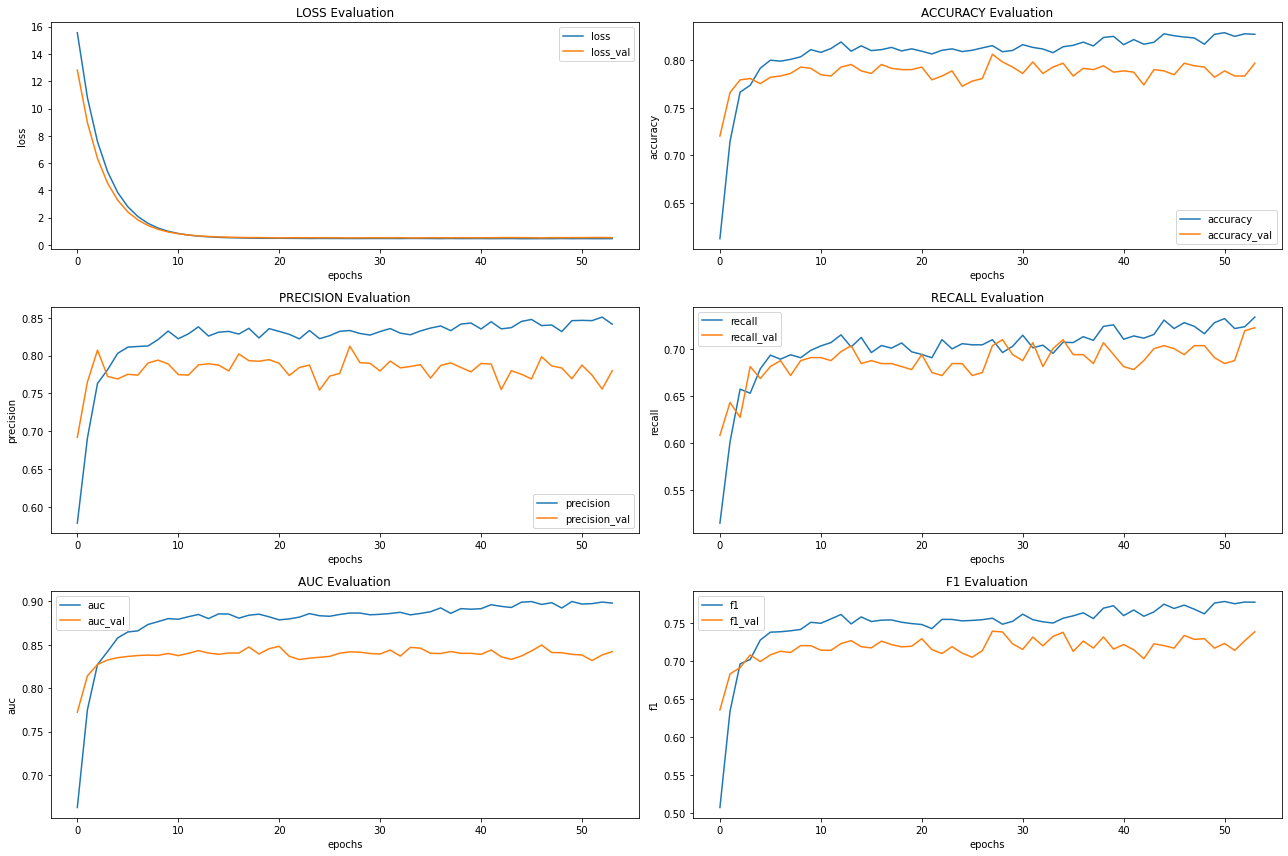

In [97]:
# Add dropout regularization

set_seed(seed)

model_3 = models.Sequential()

model_3.add(layers.Dropout(0.2, input_shape=(n_input,)))

model_3.add(layer=layers.Dense(
    units=round(n_input/2),
    activation='relu',
    kernel_regularizer=regularizers.L2(0.05)
))
model_3.add(layers.Dropout(0.2))

model_3.add(layer=layers.Dense(
    units=1,
    activation='sigmoid',
))

model_3.compile(
    optimizer=SGD(),
    loss='binary_crossentropy',
    metrics=['accuracy', precision, recall, auc, f1]
)

early_stopping = [
    EarlyStopping(monitor='val_loss', patience=20)
    ]

model_hist_3 = model_3.fit(
    np.array(X_train_combined_df_scaled),
    np.array(y_train),
    epochs=150,
    batch_size=32,
    validation_data=(X_val_combined_df_scaled, y_val),
    verbose=False,
    callbacks=early_stopping
)

plot_nn_curves(model_hist_3)

In [98]:
model_3.evaluate(X_val_combined_df_scaled, y_val, return_dict=True)

24/24 [==============================] - 0s 1ms/step - loss: 0.5343 - accuracy: 0.7970 - precision: 0.7801 - recall: 0.7229 - auc: 0.8421 - K_f1: 0.7390


{'loss': 0.5342558026313782,
 'accuracy': 0.7970430254936218,
 'precision': 0.7800687551498413,
 'recall': 0.7229299545288086,
 'auc': 0.842082679271698,
 'K_f1': 0.7390263676643372}

#### Model 3 validation results

* Loss: 0.5343
* Recall: 0.7229
* Best scores so far. Overfitting is even less present.
___

### Model 4
Changes: Add one more hidden layer with half as many nodes as the previous.

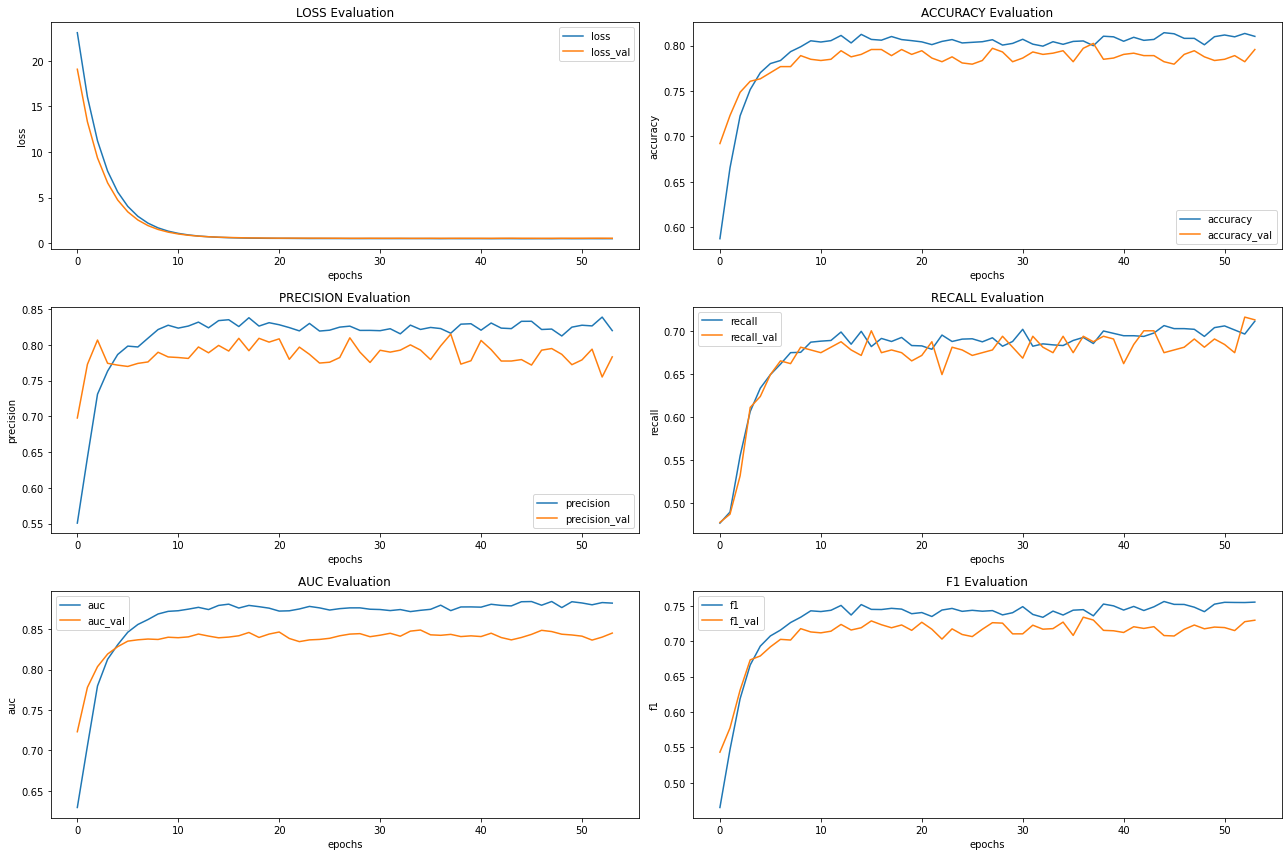

In [99]:
# Add more layers

set_seed(seed)

model_4 = models.Sequential()

model_4.add(layers.Dropout(0.2, input_shape=(n_input,)))

model_4.add(layer=layers.Dense(
    units=round(n_input/2),
    activation='relu',
    kernel_regularizer=regularizers.L2(0.05)
))
model_4.add(layers.Dropout(0.2))

model_4.add(layer=layers.Dense(
    units=round(n_input/4),
    activation='relu',
    kernel_regularizer=regularizers.L2(0.05)
))
model_4.add(layers.Dropout(0.2))

model_4.add(layer=layers.Dense(
    units=1,
    activation='sigmoid',
))

model_4.compile(
    optimizer=SGD(),
    loss='binary_crossentropy',
    metrics=['accuracy', precision, recall, auc, f1]
)

early_stopping = [
    EarlyStopping(monitor='val_loss', patience=20)
    ]

model_hist_4 = model_4.fit(
    np.array(X_train_combined_df_scaled),
    np.array(y_train),
    epochs=150,
    batch_size=32,
    validation_data=(X_val_combined_df_scaled, y_val),
    verbose=False,
    callbacks=early_stopping
)

plot_nn_curves(model_hist_4)

In [100]:
model_4.evaluate(X_val_combined_df_scaled, y_val, return_dict=True)

24/24 [==============================] - 0s 1ms/step - loss: 0.5374 - accuracy: 0.7957 - precision: 0.7832 - recall: 0.7134 - auc: 0.8452 - K_f1: 0.7299


{'loss': 0.5374418497085571,
 'accuracy': 0.7956989407539368,
 'precision': 0.7832167744636536,
 'recall': 0.7133758068084717,
 'auc': 0.8451525568962097,
 'K_f1': 0.729884922504425}

#### Model 4 validation results
* Loss: 0.5374
* Recall: 0.7134
* Scores are slightly worse than the previous iteration. The added complexity did not help the model.
___

### Model 5
Changes: Use one hidden layer with a quarter as many nodes as there are input features.

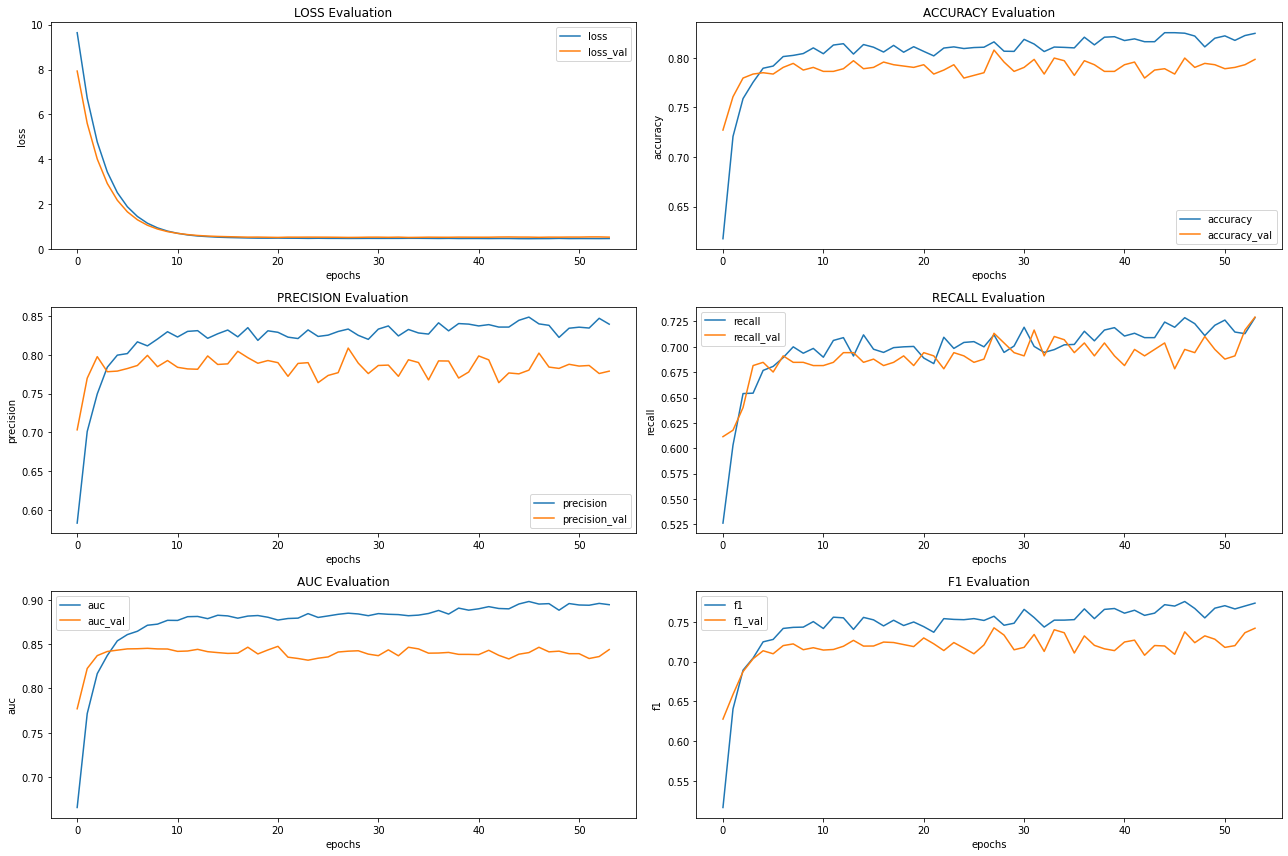

In [101]:
# Reduce nodes in single hidden layer

set_seed(seed)

model_5 = models.Sequential()

model_5.add(layers.Dropout(0.2, input_shape=(n_input,)))

model_5.add(layer=layers.Dense(
    units=round(n_input/4),
    activation='relu',
    kernel_regularizer=regularizers.L2(0.05)
))
model_5.add(layers.Dropout(0.2))

model_5.add(layer=layers.Dense(
    units=1,
    activation='sigmoid',
))

model_5.compile(
    optimizer=SGD(),
    loss='binary_crossentropy',
    metrics=['accuracy', precision, recall, auc, f1]
)

early_stopping = [
    EarlyStopping(monitor='val_loss', patience=20)
    ]

model_hist_5 = model_5.fit(
    np.array(X_train_combined_df_scaled),
    np.array(y_train),
    epochs=150,
    batch_size=32,
    validation_data=(X_val_combined_df_scaled, y_val),
    verbose=False,
    callbacks=early_stopping
)

plot_nn_curves(model_hist_5)

In [102]:
model_5.evaluate(X_val_combined_df_scaled, y_val, return_dict=True)

24/24 [==============================] - 0s 1ms/step - loss: 0.5281 - accuracy: 0.7984 - precision: 0.7789 - recall: 0.7293 - auc: 0.8438 - K_f1: 0.7419


{'loss': 0.5280575752258301,
 'accuracy': 0.7983871102333069,
 'precision': 0.7789115905761719,
 'recall': 0.7292993664741516,
 'auc': 0.8438379764556885,
 'K_f1': 0.7419411540031433}

#### Model 5 validation results
* Loss: 0.5281
* Recall: 0.7293
* Best scores so far in terms of loss and recall.
___

### Final Model Evaluation

**Model 5** is the had the lowest loss and highest recall when tested on the validation set. 

Finally, it's time to see how the model performs on the **test set**.

In [151]:
final_model = model_5

final_model.evaluate(X_test_combined_df_scaled, y_test, return_dict=True)

24/24 [==============================] - 0s 1ms/step - loss: 0.5422 - accuracy: 0.7820 - precision: 0.7295 - recall: 0.7196 - auc: 0.8394 - K_f1: 0.6853


{'loss': 0.542248010635376,
 'accuracy': 0.7819650173187256,
 'precision': 0.7294520735740662,
 'recall': 0.7195945978164673,
 'auc': 0.8393909931182861,
 'K_f1': 0.6852755546569824}

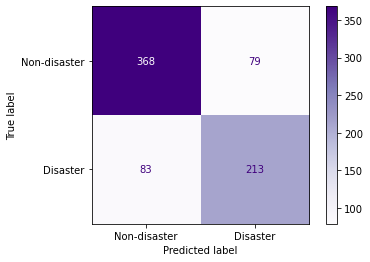

In [152]:
y_test_hat = (final_model.predict(X_test_combined_df_scaled) > 0.5).astype('int32')
ConfusionMatrixDisplay.from_predictions(y_test, y_test_hat, display_labels=['Non-disaster', 'Disaster'], cmap='Purples');

In [105]:
# Total time:
time_check()

Time check: 14 minutes and 28 seconds


#### Here's what these results mean about the final model.

* **Accuracy:** The model will correctly classify 78% of all tweets.
* **Recall:** The model will correctly classify 72% of *actual disaster tweets*. The other 28% are false negatives.
* **Precision:** Of all the tweets the model puts in the disaster category, 73% of them will be correct. The other 27% are false positives.

## Conclusion 


### Recommendations
* Discard search terms that don't yield many disaster tweets, such as "harm," "bloody," "screaming," "ruin," etc.
* Because false negeatives are still an issue, reporters should still look at all tweets, but can also be given the model's probability that a tweet is about a disaster.

### Limitations and Future Work

* The training of this model is limited by the tweets provided, as well as the search terms that were used to obtain them. Searching for things like "explosion," "fire," "suicide bomber," etc. seems like it should yield tweets about disasters. But there may be other search terms out there that the person who collected the data overlooked. That may help improve the model's performance.
* The tweets in the provided dataset show if a tweet originally contained a URL, but not if it contained a picture or video. Having that as a feature might have improved the model's performance.
* The purpose of this model is to provide *The Flatiron Post* with a feed-like tool that shows tweets related to disasters and crises. This model is just one piece of the pipeline. Other pieces include a tool that automatically requests tweets through Twitter's API, as well as a user-friendly interface.